# Insurance Prediction Challenge

## Context

https://zindi.africa/competitions/insurance-prediction-challenge

## 0. Préalable

### Importation des modules

In [16]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Advanced ML Models
import optuna  # For hyperparameter optimization
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# splitting
from sklearn.model_selection import train_test_split, StratifiedKFold
# encoding
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# metrics
from sklearn.metrics import auc, roc_curve, classification_report, ConfusionMatrixDisplay
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

# pd.options.display.max_rows = 10
# pd.options.display.max_columns = None
# pd.options.display.max_colwidth = None

In [2]:
# Set seed for reproducability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Chargement des jeux de données

In [4]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


(7160, 14)

'Test'

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


(3069, 13)

Variables identifiant et objectif

In [5]:
ID = 'Customer Id'
TARGET = 'Claim'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

Ratio entre train et test sets

In [7]:
# proportion de l'ensemble de test par rapport à l'ensemble d'apprentissage 
test.shape[0] * 100 / (train.shape[0] + test.shape[0])

30.00293283800958

Description du type des variables

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


Description des colonnes

In [11]:
def afficher_value_counts(df: pd.DataFrame) -> None:
    for colonne in list(df.columns):
        print(df[colonne].value_counts(), '\n')

afficher_value_counts(train)

Customer Id
H14663    1
H19182    1
H1571     1
H15027    1
H15026    1
         ..
H5025     1
H19098    1
H16571    1
H16570    1
H7470     1
Name: count, Length: 7160, dtype: int64 

YearOfObservation
2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: count, dtype: int64 

Insured_Period
1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
            ... 
0.435616       1
0.308743       1
0.437158       1
0.578082       1
0.030137       1
Name: count, Length: 401, dtype: int64 

Residential
0    4973
1    2187
Name: count, dtype: int64 

Building_Painted
V    5382
N    1778
Name: count, dtype: int64 

Building_Fenced
N    3608
V    3552
Name: count, dtype: int64 

Garden
O    3602
V    3551
Name: count, dtype: int64 

Settlement
R    3610
U    3550
Name: count, dtype: int64 

Building Dimension
400.0     150
500.0     120
300.0     118
450.0     117
600.0     114
         ... 
1046.0      1
763.0       1
5464.0      1
843.0       

In [12]:
afficher_value_counts(test)

Customer Id
H11920    1
H1186     1
H9420     1
H9411     1
H9421     1
         ..
H11711    1
H7932     1
H8167     1
H8168     1
H9021     1
Name: count, Length: 3069, dtype: int64 

YearOfObservation
2012    866
2013    776
2014    557
2015    479
2016    391
Name: count, dtype: int64 

Insured_Period
1.000000    2389
0.997268     197
0.000000      33
0.747945      21
0.997260      18
            ... 
0.527322       1
0.177596       1
0.926027       1
0.032877       1
0.339726       1
Name: count, Length: 198, dtype: int64 

Residential
0    2381
1     688
Name: count, dtype: int64 

Building_Painted
V    1684
N    1385
Name: count, dtype: int64 

Building_Fenced
V    2240
N     829
Name: count, dtype: int64 

Garden
V    2240
O     825
Name: count, dtype: int64 

Settlement
U    2240
R     829
Name: count, dtype: int64 

Building Dimension
400.0     68
450.0     67
300.0     62
350.0     61
600.0     58
          ..
8306.0     1
685.0      1
796.0      1
3465.0     1
865.0      1


Analyse des variables qualitatives

In [13]:
train.describe(include='object')

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


- La colonne `NumberOfWindows` contient des chiffres de 1 à 9 et deux valeurs spéciales : un point (.) et une description mathématique (>=10). Ce qui a fait de cette colonne une variable _object_. Pour un apprentissage correct, nous transformerons ces deux valeurs spéciales en chiffres, soit 0 et 10 respectivement. <br>
- La colonne `Geo_Code` a l'air de ne contenir que des nombres mais il s'avère qu'elle est de type _object_.

Analyse des variables quantitatives

In [14]:
train.describe(include='number').round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.00,7160.00,7160.00,7054.00,7160.00,6652.00,7160.00
mean,2013.67,0.91,0.31,1883.73,2.19,1964.46,0.23
std,1.38,0.24,0.46,2278.16,0.94,36.00,0.42
min,2012.00,0.00,0.00,1.00,1.00,1545.00,0.00
25%,2012.00,1.00,0.00,528.00,2.00,1960.00,0.00
50%,2013.00,1.00,0.00,1083.00,2.00,1970.00,0.00
75%,2015.00,1.00,1.00,2289.75,3.00,1980.00,0.00
max,2016.00,1.00,1.00,20940.00,4.00,2016.00,1.00


Analyse des données manquantes

In [15]:
train.isnull().sum() / train.shape[0] * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

### 1.2. Analyse du fond

Analyse et visualisation de la target

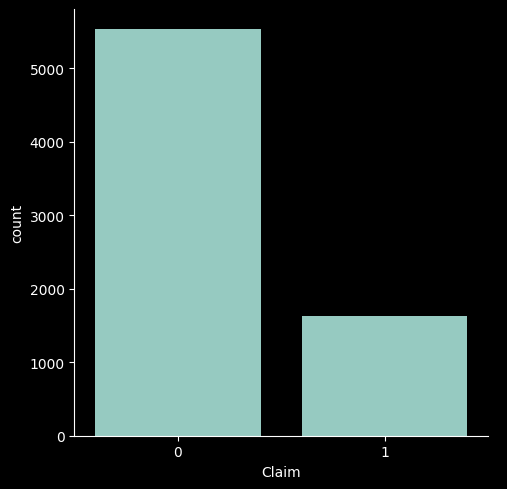

In [15]:
# explorons la distribution de la target
sns.catplot(data=train, x=TARGET, kind='count')
plt.show()

Visualisation d'autres variables

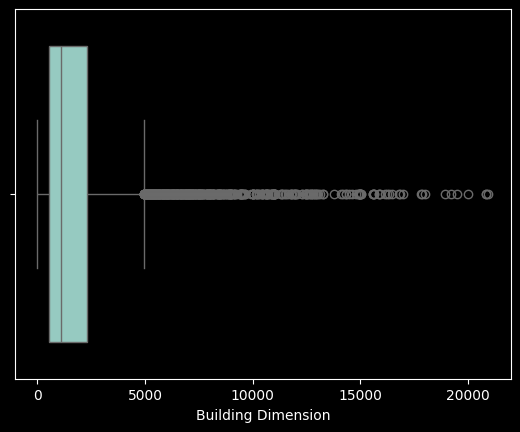

In [16]:
# Checking distribution to help decide the imputation method to use for the continous variables
sns.boxplot(x=train['Building Dimension'])
plt.show()

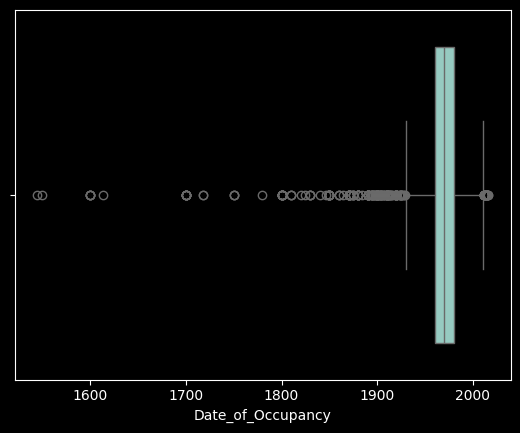

In [17]:
sns.boxplot(x=train['Date_of_Occupancy'])
plt.show()

Matrice de corrélation entre les variables

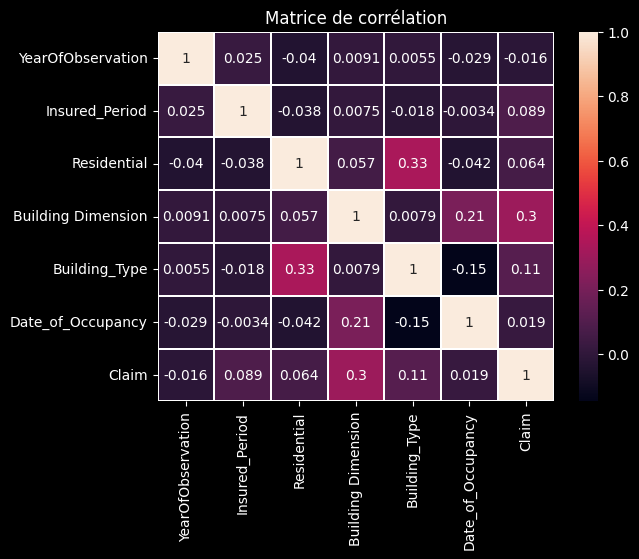

In [20]:
plt.title('Matrice de corrélation')
sns.heatmap(train.corr(numeric_only=True), linewidths=0.05, annot=True)
plt.show()

> 00 corrélation entre les variables du dataset

### Deleting missing values 

In [21]:
train1 = train.copy()
test1 = test.copy()

In [22]:
train1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
Garden                  7
Geo_Code              102
Building Dimension    106
Date_of_Occupancy     508
dtype: int64

In [23]:
test1.isnull().sum().sort_values()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Garden                  4
Building Dimension     13
Geo_Code               13
Date_of_Occupancy     728
dtype: int64

## 2. Preprocessing

In [38]:
def preprocess_data(df1: pd.DataFrame, ordinal_encoder=None, id_col='Customer Id', target_col='Claim'):
    # Copie des données
    df = df1.copy()

    # Traitement spécifique des colonnes
    if 'NumberOfWindows' in df.columns:
        df['NumberOfWindows'] = (
            df['NumberOfWindows']
            .str.strip()  # Supprime les espaces
            .replace({'.': 0, '>=10': 10})  # Remplace les valeurs spécifiques
            .astype(float)  # Convertit en float
        )

    if 'Date_of_Occupancy' in df.columns:
        current_year = 2024
        df['Building_Age'] = current_year - df['Date_of_Occupancy']

    # Convertir les colonnes en type `object`
    for col in ['YearOfObservation', 'NumberOfWindows', 'Date_of_Occupancy']:
        df[col] = df[col].astype('object')

    # Identification des colonnes catégoriques
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Encoder les colonnes catégoriques
    if ordinal_encoder is None:
        ordinal_encoder = OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=-1)
        df[categorical_cols] = ordinal_encoder.fit_transform(
            df[categorical_cols])
    else:
        df[categorical_cols] = ordinal_encoder.transform(df[categorical_cols])

    return df

In [19]:
# Combine datasets for consistent feature engineering
data = pd.concat([train, test]).reset_index(drop=True)

# Create financial ratios and transformations
# data['occupancy_observation'] = data['YearOfObservation'] - data['Date_Of_Occupancy']
data['occupancy_observation'] = data.apply(
	lambda row: row['YearOfObservation'] - row['Date_of_Occupancy'] if pd.notnull(row['YearOfObservation']) and pd.notnull(row['Date_of_Occupancy']) else np.nan,
	axis=1
)

# Convertir les colonnes en type `object`
# for col in ['loan_duration_category']:
# 	data[col] = data[col].astype('object')

# Handle categorical variables
cat_cols = data.select_dtypes(include='object').columns

# Label encoding for other categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in [ID]]:
    data[col] = le.fit_transform(data[col])

# Split back into train and test
train_df = data[data[ID].isin(train[ID].unique())]
test_df = data[data[ID].isin(test[ID].unique())]

# Define features for modeling
features_for_modelling = [col for col in train_df.columns if col not in [ID, TARGET]]

print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")
train_df.head()

The shape of train_df is: (7160, 15)
The shape of test_df is: (3069, 15)
The shape of train is: (7160, 14)
The shape of test is: (3069, 13)
The features for modelling are:
['YearOfObservation', 'Insured_Period', 'Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'NumberOfWindows', 'Geo_Code', 'occupancy_observation']


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,occupancy_observation
0,H14663,2013,1.0,0,0,1,1,1,290.0,1,1960.0,0,7,0.0,53.0
1,H2037,2015,1.0,0,1,0,0,0,490.0,1,1850.0,4,7,0.0,165.0
2,H3802,2014,1.0,0,0,1,1,1,595.0,1,1960.0,0,7,0.0,54.0
3,H3834,2013,1.0,0,1,1,1,1,2840.0,1,1960.0,0,7,0.0,53.0
4,H5053,2014,1.0,0,1,0,0,0,680.0,1,1800.0,3,7,0.0,214.0


## 3. Modelling

In [20]:
# Create stratified train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df[features_for_modelling], 
    train[TARGET], 
    stratify=train[TARGET], 
    shuffle=True,
	# test_size=0.3,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(5370, 13) (1790, 13) (5370,) (1790,)


In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

In [23]:
def calcul_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    return auc(fpr, tpr)

[I 2025-01-05 18:22:00,109] A new study created in memory with name: no-name-075051b9-b5a8-462e-a896-d9c837c5ba5f
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 188ms	remaining: 3m 35s
300:	total: 2.1s	remaining: 5.91s
600:	total: 3.74s	remaining: 3.42s
900:	total: 5.52s	remaining: 1.52s


[I 2025-01-05 18:22:07,773] Trial 0 finished with value: 0.6301325161034023 and parameters: {'booster': 'catboost', 'iterations': 1150, 'depth': 4, 'learning_rate': 0.06235420026850098, 'l2_leaf_reg': 5.454244278347485, 'bagging_temperature': 0.229102416091631, 'rsm': 0.6477655686535466}. Best is trial 0 with value: 0.6301325161034023.


1149:	total: 7.12s	remaining: 0us
0:	total: 6.63ms	remaining: 11.6s


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


300:	total: 1.9s	remaining: 9.12s
600:	total: 3.68s	remaining: 7.03s
900:	total: 5.45s	remaining: 5.13s
1200:	total: 7.21s	remaining: 3.29s
1500:	total: 9.03s	remaining: 1.5s


[I 2025-01-05 18:22:18,656] Trial 1 finished with value: 0.6232335915552907 and parameters: {'booster': 'catboost', 'iterations': 1750, 'depth': 4, 'learning_rate': 0.09351119185769298, 'l2_leaf_reg': 5.488218887757987, 'bagging_temperature': 0.7942593334730035, 'rsm': 0.38159393370560724}. Best is trial 0 with value: 0.6301325161034023.


1749:	total: 10.3s	remaining: 0us


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
[I 2025-01-05 18:22:21,371] Trial 2 finished with value: 0.5884959989784626 and parameters: {'booster': 'xgboost', 'n_estimators': 900, 'max_depth': 12, 'learning_rate': 0.07727547482954676, 'subsample': 0.8903733471185586, 'colsample_bytree': 0.755140384015724, 'gamma': 0.48325940365705683, 'min_child_weight': 3}. Best is trial 0 with value: 0.6301325161034023.
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
[I 2025-01-05 18:22:28,358] Trial 3 finished with value: 0.580396413268636 and pa

0:	total: 50.7ms	remaining: 1m 5s
300:	total: 14.8s	remaining: 49.3s
600:	total: 31s	remaining: 36s
900:	total: 47.4s	remaining: 21s
1200:	total: 1m 4s	remaining: 5.34s
1299:	total: 1m 10s	remaining: 0us


[I 2025-01-05 18:23:41,963] Trial 4 finished with value: 0.5633441871683551 and parameters: {'booster': 'catboost', 'iterations': 1300, 'depth': 12, 'learning_rate': 0.07281147466029704, 'l2_leaf_reg': 5.34522076226728, 'bagging_temperature': 0.3814225659376791, 'rsm': 0.507998353808031}. Best is trial 0 with value: 0.6301325161034023.
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
[I 2025-01-05 18:23:52,967] Trial 5 finished with value: 0.5711990295394569 and parameters: {'booster': 'xgboost', 'n_estimators': 2700, 'max_depth': 7, 'learning_rate': 0.08964293947618424, 'subsample': 0.7383838895342669, 'colsample_bytree': 0.9051491449059531, 'gamma': 0.23480761074036804, 'min_child_weight': 5}. Best is trial 0 with value: 0.6301325161034023.
c:\Users\Juste Koua

[LightGBM] [Warning] feature_fraction is set=0.6297826547584728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6297826547584728
[LightGBM] [Warning] lambda_l1 is set=0.14324541331446317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14324541331446317
[LightGBM] [Warning] lambda_l2 is set=0.7492012436242728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7492012436242728
[LightGBM] [Warning] bagging_fraction is set=0.8948186236016826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948186236016826
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6297826547584728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6297826547584728
[LightGBM] [Warning] lambda_l1 is set=0.14324541331446317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14324541331446317
[LightGBM] [Warning] lambda_l2 is set=0.7492012436242728, reg

[I 2025-01-05 18:23:55,000] Trial 6 finished with value: 0.5857736727107631 and parameters: {'booster': 'lightgbm', 'n_estimators': 2100, 'max_depth': 7, 'learning_rate': 0.013325055792908647, 'num_leaves': 12, 'feature_fraction': 0.6297826547584728, 'bagging_fraction': 0.8948186236016826, 'lambda_l1': 0.14324541331446317, 'lambda_l2': 0.7492012436242728}. Best is trial 0 with value: 0.6301325161034023.


[LightGBM] [Warning] feature_fraction is set=0.6297826547584728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6297826547584728
[LightGBM] [Warning] lambda_l1 is set=0.14324541331446317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14324541331446317
[LightGBM] [Warning] lambda_l2 is set=0.7492012436242728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7492012436242728
[LightGBM] [Warning] bagging_fraction is set=0.8948186236016826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948186236016826
[LightGBM] [Warning] feature_fraction is set=0.8737154187546925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737154187546925
[LightGBM] [Warning] lambda_l1 is set=0.5713355999874612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713355999874612
[LightGBM] [Warning] lambda_l2 is set=0.7374226778659618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7374226778659618
[LightGBM

c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [2, 20] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 12].
  warnings.warn(
[I 2025-01-05 18:23:57,314] Trial 7 finished with value: 0.5834166879486962 and parameters: {'booster': 'lightgbm', 'n_estimators': 2300, 'max_depth': 8, 'learning_rate': 0.026896116823252048, 'num_leaves': 12, 'feature_fraction': 0.8737154187546925, 'bagging_fraction': 0.9243024347508545, 'lambda_l1': 0.5713355999874612, 'lambda_l2': 0.7374226778659618}. Best is trial 0 with value: 0.6301325161034023.


[LightGBM] [Warning] feature_fraction is set=0.8737154187546925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737154187546925
[LightGBM] [Warning] lambda_l1 is set=0.5713355999874612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713355999874612
[LightGBM] [Warning] lambda_l2 is set=0.7374226778659618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7374226778659618
[LightGBM] [Warning] bagging_fraction is set=0.9243024347508545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243024347508545


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 12.8ms	remaining: 16.6s
300:	total: 4.17s	remaining: 13.8s
600:	total: 8.22s	remaining: 9.56s
900:	total: 12.4s	remaining: 5.49s
1200:	total: 17.2s	remaining: 1.42s
1299:	total: 18.6s	remaining: 0us


[I 2025-01-05 18:24:16,706] Trial 8 finished with value: 0.5836295082432394 and parameters: {'booster': 'catboost', 'iterations': 1300, 'depth': 9, 'learning_rate': 0.0977158298908314, 'l2_leaf_reg': 9.468186492733096, 'bagging_temperature': 0.2510530761651148, 'rsm': 0.3256453556500875}. Best is trial 0 with value: 0.6301325161034023.
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 56ms	remaining: 2m 36s
300:	total: 14.3s	remaining: 1m 58s
600:	total: 30s	remaining: 1m 49s
900:	total: 46.3s	remaining: 1m 37s
1200:	total: 1m 2s	remaining: 1m 23s
1500:	total: 1m 19s	remaining: 1m 9s
1800:	total: 1m 36s	remaining: 53.4s
2100:	total: 1m 53s	remaining: 37.8s
2400:	total: 2m 12s	remaining: 22.1s
2700:	total: 2m 30s	remaining: 5.5s
2799:	total: 2m 35s	remaining: 0us


[I 2025-01-05 18:27:00,039] Trial 9 finished with value: 0.5599709854998438 and parameters: {'booster': 'catboost', 'iterations': 2800, 'depth': 12, 'learning_rate': 0.06963265559742751, 'l2_leaf_reg': 6.67897393227067, 'bagging_temperature': 0.1607758282719367, 'rsm': 0.41892684896225574}. Best is trial 0 with value: 0.6301325161034023.
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 81.6ms	remaining: 20.3s


[I 2025-01-05 18:27:02,337] Trial 10 finished with value: 0.6388297721404047 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 3, 'learning_rate': 0.04767894489334537, 'l2_leaf_reg': 1.5848112685485223, 'bagging_temperature': 0.6729309176584872, 'rsm': 0.8021947496048368}. Best is trial 10 with value: 0.6388297721404047.


249:	total: 1.98s	remaining: 0us
0:	total: 2.92ms	remaining: 289ms


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(
[I 2025-01-05 18:27:02,934] Trial 11 finished with value: 0.6328193723220112 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.045157905260298024, 'l2_leaf_reg': 1.2033560976127298, 'bagging_temperature': 0.7048400107285474, 'rsm': 0.795493081135822}. Best is trial 10 with value: 0.6388297721404047.


99:	total: 361ms	remaining: 0us
0:	total: 2.83ms	remaining: 281ms


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(
[I 2025-01-05 18:27:03,454] Trial 12 finished with value: 0.6293415340086831 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.04592526961977241, 'l2_leaf_reg': 1.5861083775135576, 'bagging_temperature': 0.7413617605133624, 'rsm': 0.8746823127103894}. Best is trial 10 with value: 0.6388297721404047.


99:	total: 295ms	remaining: 0us
0:	total: 5.46ms	remaining: 541ms


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(
[I 2025-01-05 18:27:04,312] Trial 13 finished with value: 0.6312551431571181 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 6, 'learning_rate': 0.043660475564681944, 'l2_leaf_reg': 1.1920995488632453, 'bagging_temperature': 0.6017941497419563, 'rsm': 0.8151295390374111}. Best is trial 10 with value: 0.6388297721404047.


99:	total: 623ms	remaining: 0us


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 12.3ms	remaining: 6.75s
300:	total: 2.98s	remaining: 2.46s


[I 2025-01-05 18:27:10,324] Trial 14 finished with value: 0.629304290457138 and parameters: {'booster': 'catboost', 'iterations': 550, 'depth': 6, 'learning_rate': 0.03301248029848205, 'l2_leaf_reg': 2.963536070540479, 'bagging_temperature': 0.992998552816229, 'rsm': 0.7271602689650539}. Best is trial 10 with value: 0.6388297721404047.


549:	total: 5.49s	remaining: 0us
[LightGBM] [Warning] feature_fraction is set=0.9949438109381377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949438109381377
[LightGBM] [Warning] lambda_l1 is set=0.9652287819229988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9652287819229988
[LightGBM] [Warning] lambda_l2 is set=0.045154379088513164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.045154379088513164
[LightGBM] [Warning] bagging_fraction is set=0.6397939278670998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397939278670998
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9949438109381377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949438109381377
[LightGBM] [Warning] lambda_l1 is set=0.9652287819229988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9652287819229988
[LightGBM] [Warning] lambda_

c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [2, 20] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 12].
  warnings.warn(
[I 2025-01-05 18:27:10,502] Trial 15 finished with value: 0.5409785477143101 and parameters: {'booster': 'lightgbm', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.050929591134091, 'num_leaves': 2, 'feature_fraction': 0.9949438109381377, 'bagging_fraction': 0.6397939278670998, 'lambda_l1': 0.9652287819229988, 'lambda_l2': 0.045154379088513164}. Best is trial 10 with value: 0.6388297721404047.


[LightGBM] [Warning] feature_fraction is set=0.9949438109381377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949438109381377
[LightGBM] [Warning] lambda_l1 is set=0.9652287819229988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9652287819229988
[LightGBM] [Warning] lambda_l2 is set=0.045154379088513164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.045154379088513164
[LightGBM] [Warning] bagging_fraction is set=0.6397939278670998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397939278670998
0:	total: 7.39ms	remaining: 5.17s


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


300:	total: 2.14s	remaining: 2.83s
600:	total: 4.3s	remaining: 708ms


[I 2025-01-05 18:27:15,751] Trial 16 finished with value: 0.638269345364774 and parameters: {'booster': 'catboost', 'iterations': 700, 'depth': 3, 'learning_rate': 0.03139914555281368, 'l2_leaf_reg': 2.976055996978915, 'bagging_temperature': 0.5902073003686519, 'rsm': 0.7397442231794421}. Best is trial 10 with value: 0.6388297721404047.


699:	total: 4.88s	remaining: 0us


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=150, but the range is not divisible by `step`. It will be replaced by [100, 2950].
  warnings.warn(


0:	total: 19.9ms	remaining: 13.9s
300:	total: 2.44s	remaining: 3.24s
600:	total: 5.03s	remaining: 829ms


[I 2025-01-05 18:27:22,031] Trial 17 finished with value: 0.6377443886382339 and parameters: {'booster': 'catboost', 'iterations': 700, 'depth': 6, 'learning_rate': 0.006287404944114162, 'l2_leaf_reg': 3.711227699838873, 'bagging_temperature': 0.4487666759832527, 'rsm': 0.6594378207508853}. Best is trial 10 with value: 0.6388297721404047.


699:	total: 5.75s	remaining: 0us


c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
[I 2025-01-05 18:27:32,424] Trial 18 finished with value: 0.5746183422717857 and parameters: {'booster': 'xgboost', 'n_estimators': 1100, 'max_depth': 12, 'learning_rate': 0.029001271453748746, 'subsample': 0.6300339118134012, 'colsample_bytree': 0.989962954391434, 'gamma': 0.016422336010360417, 'min_child_weight': 1}. Best is trial 10 with value: 0.6388297721404047.
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [100, 3000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 2900].
  warnings.warn(
c:\Users\Juste Kouassi\AppData\Local\Programs\Python\Python312\Lib\site-pack

[LightGBM] [Warning] feature_fraction is set=0.6024001008121345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024001008121345
[LightGBM] [Warning] lambda_l1 is set=0.0033630636335638675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033630636335638675
[LightGBM] [Warning] lambda_l2 is set=0.10531777414233345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10531777414233345
[LightGBM] [Warning] bagging_fraction is set=0.6232866353974427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6232866353974427
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6024001008121345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024001008121345
[LightGBM] [Warning] lambda_l1 is set=0.0033630636335638675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033630636335638675
[LightGBM] [Warning] lambda_l2 is set=0.10531777414

[I 2025-01-05 18:27:32,800] Trial 19 finished with value: 0.5653251894100623 and parameters: {'booster': 'lightgbm', 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0588066833426035, 'num_leaves': 2, 'feature_fraction': 0.6024001008121345, 'bagging_fraction': 0.6232866353974427, 'lambda_l1': 0.0033630636335638675, 'lambda_l2': 0.10531777414233345}. Best is trial 10 with value: 0.6388297721404047.


[LightGBM] [Warning] feature_fraction is set=0.6024001008121345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024001008121345
[LightGBM] [Warning] lambda_l1 is set=0.0033630636335638675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033630636335638675
[LightGBM] [Warning] lambda_l2 is set=0.10531777414233345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10531777414233345
[LightGBM] [Warning] bagging_fraction is set=0.6232866353974427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6232866353974427
Best Hyperparameters: {'booster': 'catboost', 'iterations': 250, 'depth': 3, 'learning_rate': 0.04767894489334537, 'l2_leaf_reg': 1.5848112685485223, 'bagging_temperature': 0.6729309176584872, 'rsm': 0.8021947496048368}
0:	learn: 0.6737407	total: 8.22ms	remaining: 2.05s
249:	learn: 0.4548863	total: 1.51s	remaining: 0us
F1 Score: 0.5753

Classification Report:
               precision    recall  f1-score   support

      

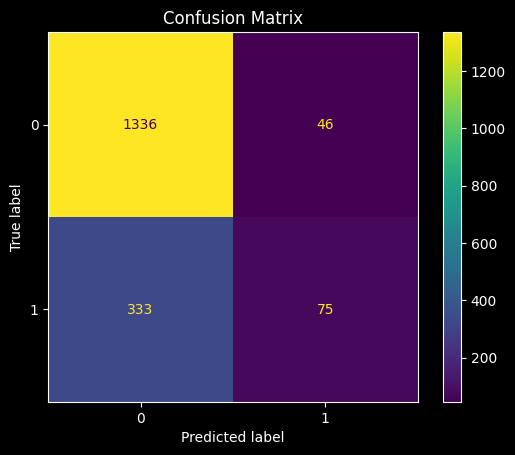

In [31]:
# Fonction objective pour Optuna
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Tries different boosting algorithms with various hyperparameters.
    """
    # Sélectionner le booster (modèle)
    booster = trial.suggest_categorical("booster", ["xgboost", "lightgbm", "catboost"])
    # booster = trial.suggest_categorical("booster", ["xgboost", "lightgbm"])
    # seed = trial.suggest_int("random_state", 0, 45)
    seed = SEED

    if booster == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 2, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "random_state": seed,
            "scale_pos_weight": len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        }
        model = XGBClassifier(**params, eval_metric="logloss")

    elif booster == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 2, 20, step=10),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "random_state": seed,
            "force_row_wise": True
        }
        model = LGBMClassifier(**params)

    elif booster == "catboost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 3000, step=100),
            "depth": trial.suggest_int("depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),
            "rsm": trial.suggest_float("rsm", 0.3, 0.9),
            "random_state": seed,
            "border_count": 128,
            "objective": "Logloss",
            'eval_metric': 'AUC',
            'class_weights': [1, 5],
            "early_stopping_rounds": 100,
            "verbose": 300
        }
        model = CatBoostClassifier(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return calcul_auc(y_valid, y_pred)


# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
if best_params["booster"] == "xgboost":
    del best_params["booster"]
    final_model = XGBClassifier(**best_params, eval_metric="logloss")
elif best_params["booster"] == "lightgbm":
    final_model = LGBMClassifier(**best_params)
elif best_params["booster"] == "catboost":
    del best_params["booster"]
    final_model = CatBoostClassifier(**best_params, verbose=300)

# Train and evaluate final model
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_valid)

# Print model performance metrics
f1 = calcul_auc(y_valid, y_pred)
print(f"\nSocre AUC : {f1:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=final_model.classes_,
)
plt.title("Confusion Matrix")
plt.show()

### Entrainement du modèle avec CatBoost

In [ ]:
# Selection des variables independantes et de la variable cible
X = train_pp.drop([ID, TARGET], axis=1)
y = train_pp[TARGET]

# Le decoupage des données entre l'ensemble pour l'apprentissage et le test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'rsm': 0.6,
    'depth': 6,
    'l2_leaf_reg': 5,
    'bagging_temperature': 1.0,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    # 'use_best_model': True,
    'class_weights': [1, 5],  # Exemples de poids pour classes déséquilibrées
}

clf = CatBoostClassifier(**params)
clf.fit(X_train, y_train, verbose=100)

# Predictions des valeurs cibles pour l'ensemble des variables du test
y_pred = clf.predict(X_test)

metrique = calcul_auc(y_test, y_pred)

print(f"Taux d'erreur du {str(clf)} : {metrique}")

0:	total: 9.06ms	remaining: 18.1s
100:	total: 809ms	remaining: 15.2s
200:	total: 1.54s	remaining: 13.7s
300:	total: 2.4s	remaining: 13.6s
400:	total: 3.3s	remaining: 13.2s
500:	total: 4.13s	remaining: 12.3s
600:	total: 4.92s	remaining: 11.4s
700:	total: 5.64s	remaining: 10.5s
800:	total: 6.46s	remaining: 9.66s
900:	total: 7.42s	remaining: 9.06s
1000:	total: 8.29s	remaining: 8.27s
1100:	total: 9.06s	remaining: 7.4s
1200:	total: 9.8s	remaining: 6.52s
1300:	total: 10.7s	remaining: 5.75s
1400:	total: 11.8s	remaining: 5.03s
1500:	total: 12.7s	remaining: 4.21s
1600:	total: 13.6s	remaining: 3.39s
1700:	total: 14.6s	remaining: 2.56s
1800:	total: 15.5s	remaining: 1.72s
1900:	total: 16.6s	remaining: 862ms
1999:	total: 17.5s	remaining: 0us
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x0000015F0BB11BB0> : 0.6744281571014245


0.6744281571014245

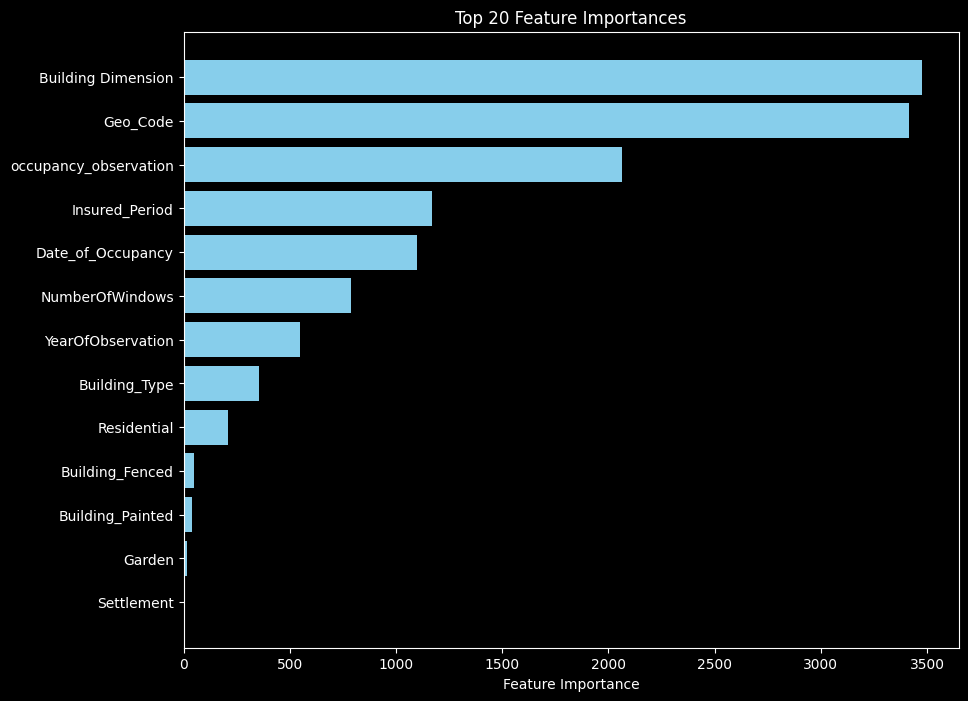

In [27]:
feature_importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(50)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

## Submission

Visualisation du fichier d'exemple de soumission

In [52]:
sample_submission.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


Création de notre fichier de soumission

In [29]:
# Generate predictions for test set
test_predictions = final_model.predict(test_df[features_for_modelling])

# Create submission dataframe
test_df[TARGET] = test_predictions
sub = test_df[[ID, TARGET]]
sub.head()

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] feature_fraction is set=0.9482065485287381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482065485287381
[LightGBM] [Warning] lambda_l1 is set=0.37445004179135033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37445004179135033
[LightGBM] [Warning] lambda_l2 is set=0.565838925504179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.565838925504179
[LightGBM] [Warning] bagging_fraction is set=0.7553057156621784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7553057156621784


C:\Users\Juste Kouassi\AppData\Local\Temp\ipykernel_13356\71994349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_predictions


,Customer Id,Claim
7160,H11920,0
7161,H11921,0
7162,H9805,0
7163,H7493,0
7164,H7494,0


In [30]:
# Save predictions to CSV file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
# sub.to_csv(f'submissions/submission_{today}.csv', index=False)
sub.to_csv(f'submissions/submission_{today}.csv', index=False)

In [26]:
# Faire des prédictions sur l'ensemble de données pour le test
test_df = test_pp.drop([ID], axis = 1)
predictions = final_model.predict(test_df)

# Génerer un dataframe pour la soumission
sub_file = pd.DataFrame({ID: test[ID], TARGET: predictions})

# Create file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
sub_file.to_csv(f'submissions/submission_{today}.csv', index=False)

sub_file.sample(5)

NameError: name 'test_pp' is not defined

## Model saving

In [ ]:
# Save the model as a pickle in a file
file_name = 'catboost_gpt'
joblib.dump(clf, f'models/{file_name}.pkl')

['models/catboost_gpt.pkl']